In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

Current venv: C:\Users\LukasGrahl\Documents\GIT\memoire1\env_macro_rbc
DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [73]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

from itertools import chain
import os
import time

from scipy.stats import gamma, norm, beta, uniform
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver


from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import set_up_kalman_filter, kalman_filter, sample_from_priors, solve_updated_mod, get_arr_pdf_from_dist, kalman_filter_forecast
from src.arima import get_arma_model
from src.utils import printProgBar, get_most_recent_mod_output

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [23]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [10]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors, mod6_params, mod6_priors
mods = {
    # 'mod4_rbc_vanilla': {'params': mod4_params,
    #                      'priors': mod4_priors,
    #                      'is_lin': False},
    # 'mod5_nk_vanilla': {'params': mod5_params,
    #                     'priors': mod5_priors,
    #                         'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'w', 'r', 'lambda']
    # 'is_lin': False},    
    'mod6_nk_energy_lin2': {'params': mod6_params,
                                   'is_lin': True,
                                   'priors': mod6_priors,
                        'plot_vars': ['S', 'Y', 'C']},
}

# load model
for key in mods.keys():
    # load
    mods[key]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{key}.gcn'), verbose=False)
    
    # solve
    _, mods[key]['mod'] = solve_updated_mod(mods[key]['mod'], verbose=True, model_is_linear=mods[key]['is_lin'])
    assert _ == True
    
    # get shocks
    mods[key]['shocks'] = [item.base_name for item in mods[key]['mod'].shocks]
    
    # load posterior estimates
    file_name = get_most_recent_mod_output(POST_EST_DIR, f'{key}_accepted')
    print(file_name)
    mods[key]['post_out'] = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

Steady state found! Sum of squared residuals is 0.0
Solution found, sum of squared residuals:  7.730857881701882e-33
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.
mod6_nk_energy_lin2_accepted_20230426_1326.nc


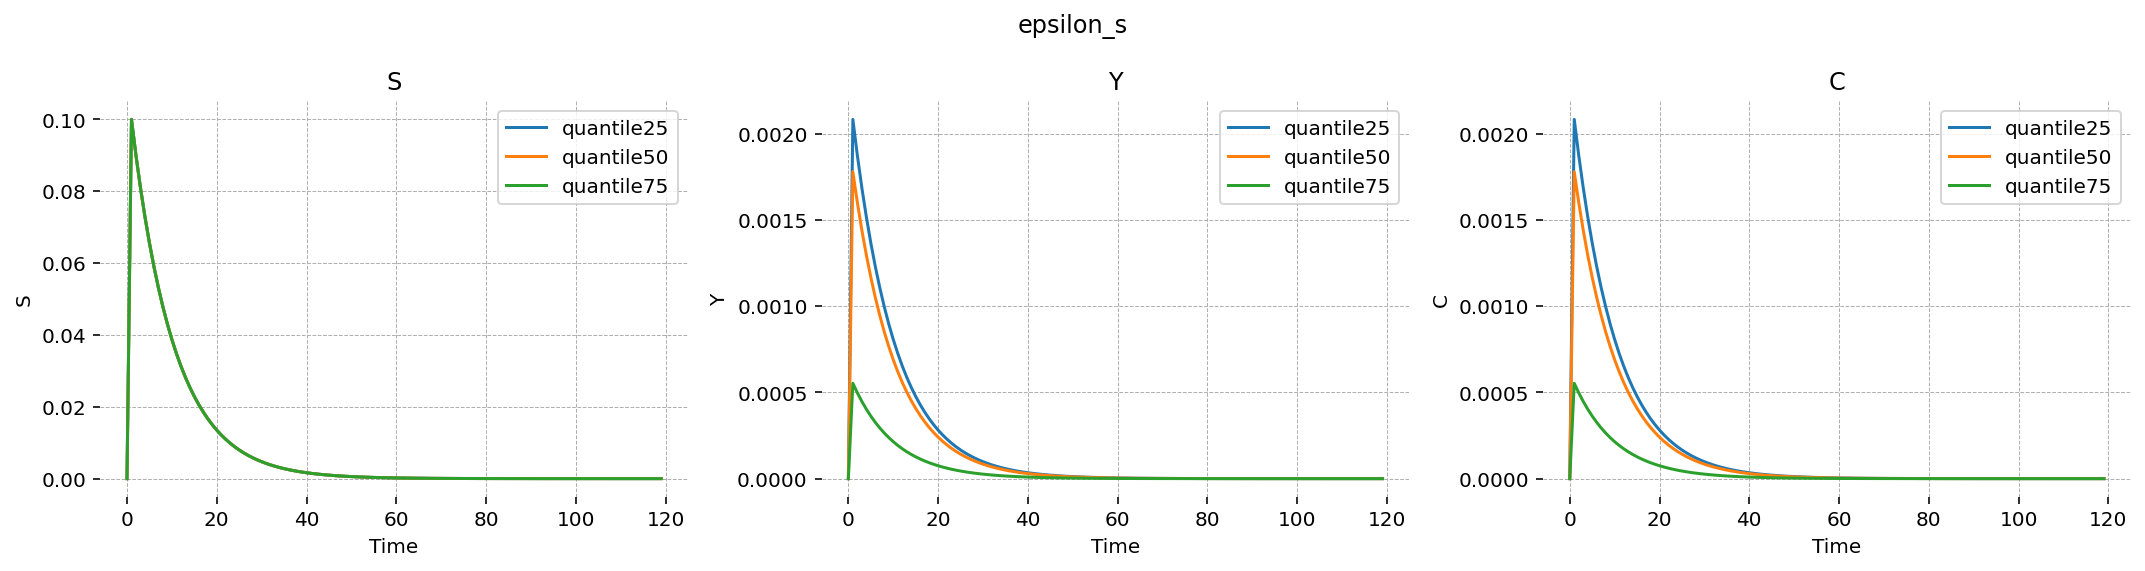

In [15]:
shock_size = .1
sim_length = 120

param_sets = [
    dict(zip(xarr.parameter.values, xarr.posterior_q1.values)),
    dict(zip(xarr.parameter.values, xarr.posterior_q2.values)),
    dict(zip(xarr.parameter.values, xarr.posterior_q3.values))
]

irfs = []
# get irf for each model
for i, params in enumerate(param_sets):
    mod.free_param_dict.update(params)
    _, mod = solve_updated_mod(mod, verbose=False, model_is_linear=mod_is_linear)
    assert _ == True
    irfs.append(mod.impulse_response_function(simulation_length=sim_length, shock_size=shock_size))
    mod.free_param_dict.update(mod_params)
    

# set plotting shock
shock = 'epsilon_s'
for i, irf in enumerate(irfs):
    irfs[i] = irf.unstack().loc[:, shock].unstack().copy()

# plot shocks
plot_dfs([df[mods[name]['plot_vars']] for df in irfs],
         sns.lineplot,
         fig_title=shock,
         figsize=(15, 4),
         legend=['quantile' + str(x) for x in [25, 50, 75]]
        )

In [51]:
# random draw samples
np.random.choice(xarr.draw, 100)

array([5803, 6251, 5096, 6547, 9700, 8970, 7313, 5301, 9706, 5359, 9118,
       6682, 5035, 6183, 5367, 7506, 6464, 7839, 9418, 6255, 8146, 6642,
       9390, 7052, 6659, 7263, 8869, 8540, 5199, 8725, 7043, 8814, 9850,
       8628, 8311, 5699, 7896, 8207, 6968, 5785, 7733, 8604, 9062, 9714,
       5822, 9232, 5197, 9921, 9660, 8196, 9803, 5900, 5886, 8302, 5835,
       6052, 7864, 9235, 9995, 6259, 6633, 9111, 6066, 5108, 9812, 5723,
       6219, 6606, 5169, 9261, 6811, 5529, 9251, 5984, 6806, 8632, 7230,
       9232, 9930, 7247, 6612, 7976, 9654, 8236, 9566, 9470, 9578, 5576,
       6913, 9531, 5390, 9637, 7585, 6596, 9780, 6295, 9211, 5402, 5406,
       6204])

In [52]:
dict(zip(xarr.parameter.values, xarr.posterior_q2.values))

{'M': 8.739505319926351,
 'alpha_m': 0.33319767641220677,
 'alpha_n': 0.33937271418828213,
 'epsilon': 0.33493614652616316}

In [59]:
def forecast_kalman(model, observed_vars: list, train_data, test_data, parameters):
    shock_names = [x.base_name for x in mod.shocks]
    state_variables = [x.base_name for x in mod.variables]
    
    # update mod params with posterior mean
    model.free_param_dict.update(parameters)
    _, shocks = sample_from_priors(prior_dist, mod_params, shock_names)

    solved, model = solve_updated_mod(model, verbose=False)
    if not solved: raise ValueError('Model not solved')

    T, R = model.T.values, model.R.values
    H, Z, T, R, QN, zs = set_up_kalman_filter(R=R, T=T, observed_data=train[observed_vars].values, observed_vars=observed_vars, 
                                              shock_names=shock_names, shocks_drawn_prior=shocks, state_variables=state_variables, H0=.01)

    kfilter = KalmanFilter(len(state_variables), len(observed_vars))
    kfilter.F = T
    kfilter.Q = QN
    kfilter.H = Z
    kfilter.R = H
   
    # filtering
    saver = Saver(kfilter)
    mu, cov, _, _ = kfilter.batch_filter(zs, saver=saver)
    ll_train = saver.log_likelihood

    mu_df_train = pd.DataFrame(mu.reshape(len(mu), -1),
                         columns=[item.base_name for item in mod.variables],
                         index=train.index)
    cov_df_train = pd.DataFrame(cov.diagonal(axis1=1, axis2=2), columns=[item.base_name for item in mod.variables], index=train.index)

    
    # forecasting
    mu, cov, ll_test = kalman_filter_forecast(kfilter, test[observed_vars].values)

    mu_df_test = pd.DataFrame(mu.reshape(len(mu), -1),
                              columns=[item.base_name for item in mod.variables],
                              index=test.index)
    cov_df_test = pd.DataFrame(cov.diagonal(axis1=1, axis2=2), columns=[item.base_name for item in mod.variables], index=test.index)
    
    return mu_df_train, cov_df_train, ll_test, mu_df_test, cov_df_test, ll_train

In [65]:
xarr.posterior_q2

<xarray.DataArray 'posterior_q2' (parameter: 4)>
array([8.739505, 0.333198, 0.339373, 0.334936])
Coordinates:
  * parameter  (parameter) object 'M' 'alpha_m' 'alpha_n' 'epsilon'

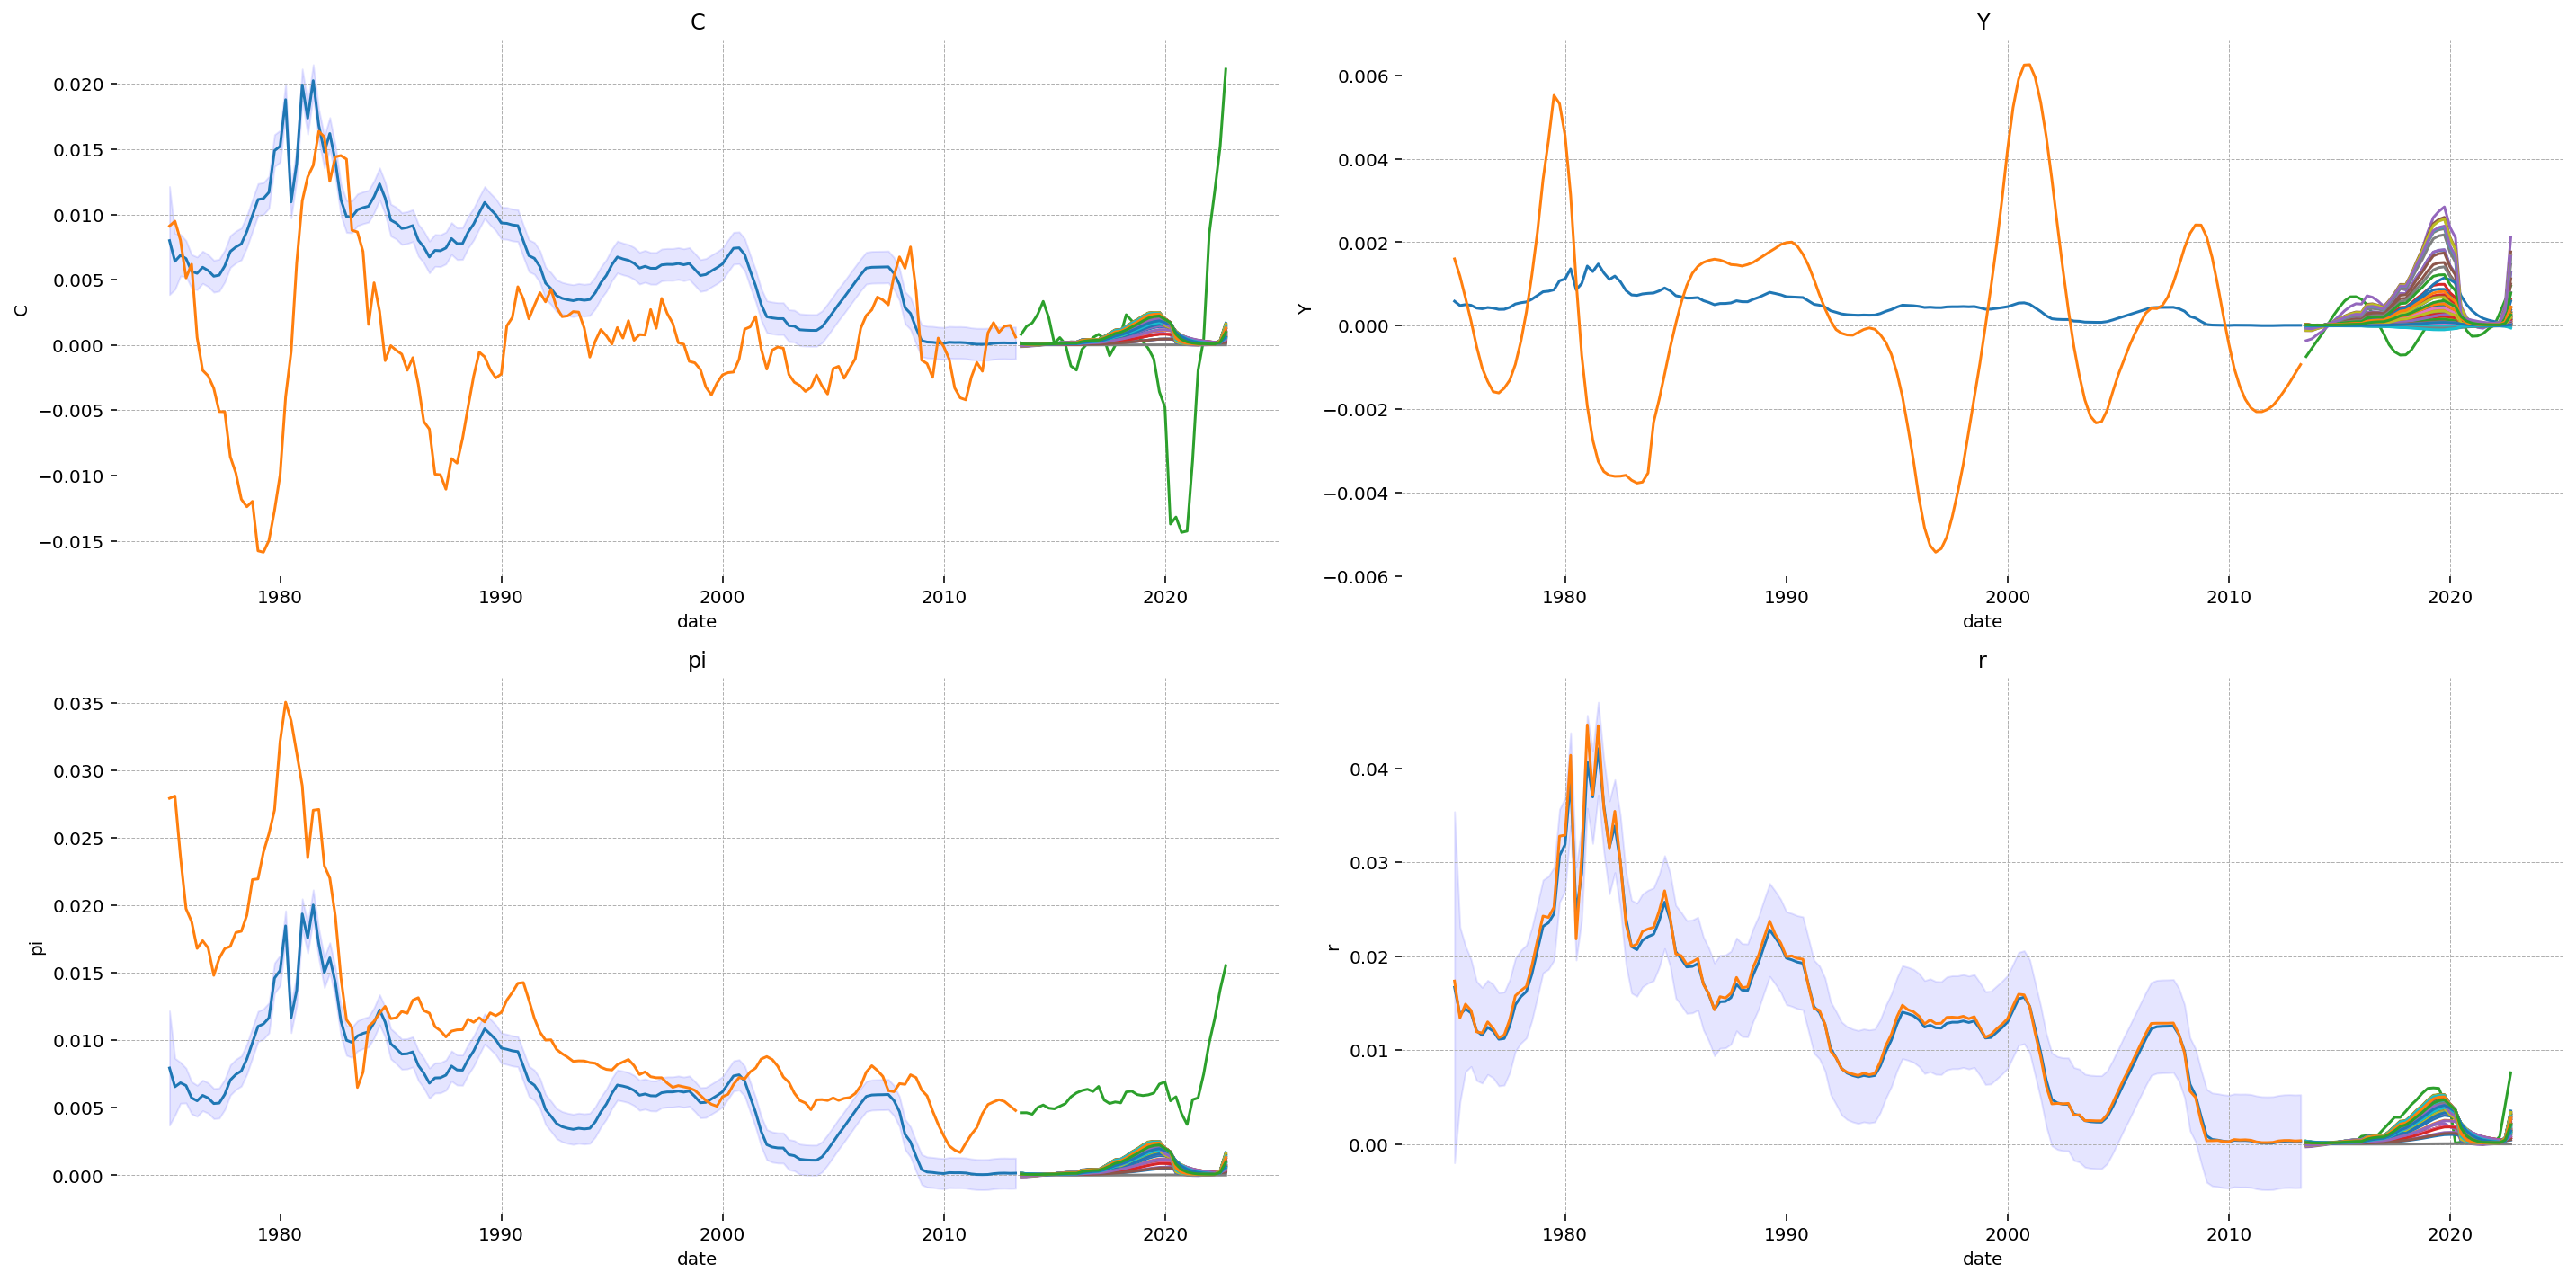

In [88]:
observed_vars = ["Y", "r"]
# split train and test
train = df[df['is_test'] == False][[col for col in state_variables if col in df.columns]].copy()
test = df[df['is_test'] == True][[col for col in state_variables if col in df.columns]].copy()

i = 5803

params = dict(zip(xarr.parameter.values, xarr.posterior_q2))
mu_df_train, cov_df_train, ll_test, mu_df_test, cov_df_test, ll_train = forecast_kalman(mod, observed_vars, train, test, params)
              
mu_df_tests = []
n_draws = 100
for i in np.random.choice(xarr.draw, n_draws):
    params = dict(zip(xarr.parameter.values, xarr.sel(draw=i).posterior))
    _, _, _, mu_df_test, cov_df_test, ll_train = forecast_kalman(mod, observed_vars, train, test, params)
    mu_df_tests.append(mu_df_test[train.columns])
    

# plot results

dfs = [mu_df_train[train.columns].iloc[ind:], train.iloc[ind:], test]
dfs.extend(mu_df_tests)

ind = 0
plot_dfs(
    dfs,
    plotfunc=sns.lineplot, 
    dfs_cov=[*chain([cov_df.iloc[ind:]], [None] * (n_draws + 2))],
    # legend=['filter_train', 'data_train', 'filter_test', 'data_test'],
    cols=2,
    figsize=(20, 5)
)